In [169]:
import os

os.environ["HF_HOME"] = "/NS/llm-artifacts/nobackup/HF_HOME"  # set HF cache dir if desired
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [170]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer

# Load Results

In [171]:
hf_path = 'HF_Outputs/hf_logprobs.jsonl'

df_hf_logprobs = pd.read_json(hf_path, lines=True)

df_hf_logprobs_with_bos = pd.read_json('HF_Outputs/hf_logprobs_with_bos.jsonl', lines=True)

In [158]:
sgl_backends = ['fa3', 'flashinfer', 'triton', 'torch_native']

sgl_dfs = {}

for backend in sgl_backends:
    sgl_dfs[backend] = {}

    if backend != 'torch_native':
        deterministic_path = f'SGL_Outputs/sgl_logprobs_attn_backend_{backend}_deterministic_true.jsonl'
        df_sgl_deterministic = pd.read_json(deterministic_path, lines=True)
        sgl_dfs[backend] = {
            'det': df_sgl_deterministic,
        }
    
    non_deterministic_path = f'SGL_Outputs/sgl_logprobs_attn_backend_{backend}_deterministic_false.jsonl'

    df_sgl_nondeterministic = pd.read_json(non_deterministic_path, lines=True)

    sgl_dfs[backend]['non_det'] = df_sgl_nondeterministic

# Load Data

In [159]:
df_dataset = pd.read_json('test_data.jsonl', lines=True)

# Load Tokenizer
To denormalize the normalized log probabilities returned by SGLang - https://docs.sglang.io/references/frontend/choices_methods.html#token-length-normalized

In [160]:
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B")

# Get Token Count for Each Unique Choice

In [161]:
all_choice_lists = df_dataset['choices'].to_list()

choice_to_token_count_map = {}

for choice_list in all_choice_lists:
    for choice in choice_list:
        if choice not in choice_to_token_count_map:
            choice_to_token_count_map[choice] = len(tokenizer.encode(" " + choice, add_special_tokens=False)) # Space is added before to mimic the situation where the token is present in the middle and not at the start.

In [162]:
denormalizing_constants_row_wise = []

for choice_list in all_choice_lists:
    sublist = []
    for choice in choice_list:
        sublist.append(choice_to_token_count_map[choice])
    denormalizing_constants_row_wise.append(sublist)

In [163]:
def denormalize_choice_logliks(df, denormalizing_constants_row_wise):
    """
    Denormalizes df['choice_logliks'] using row-wise multiplicative constants.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame with a column 'choice_logliks' where each entry is a list of normalized values.
    denormalizing_constants_row_wise : list of lists
        Each sublist contains multiplicative constants that correspond to the list in the same row of df.

    Returns
    -------
    pandas.DataFrame
        The original DataFrame with a new column 'choice_logliks_denorm'.
    """

    def denorm_row(values, constants):
        if len(values) != len(constants):
            raise ValueError("Length mismatch between values and denormalizing constants.")
        return [v * c for v, c in zip(values, constants)]

    df["choice_logliks_denorm"] = [
        denorm_row(vals, consts)
        for vals, consts in zip(df["choice_logliks"], denormalizing_constants_row_wise)
    ]

    return df

In [164]:
for backend, dfs in sgl_dfs.items():
    for det_type, df in dfs.items():
        df = denormalize_choice_logliks(df, denormalizing_constants_row_wise)
        sgl_dfs[backend][det_type] = df  # update the dictionary

# Let's Only Focus on the first row and compare the logprobs across all runs

In [165]:
first_row_log_probs = {}

for backend, dfs in sgl_dfs.items():
    for det_type, df in dfs.items():
        first_row_log_probs[f'{backend}--{det_type}'] = df.iloc[0]['choice_logliks_denorm']

In [166]:
first_row_log_probs['hf'] = df_hf_logprobs.iloc[0]['choice_logliks'] # No need to denorm as it was already just summed and not normalized per choice

In [167]:
first_row_log_probs['hf_with_bos'] = df_hf_logprobs_with_bos.iloc[0]['choice_logliks'] # No need to denorm as it was already just summed and not normalized per choice

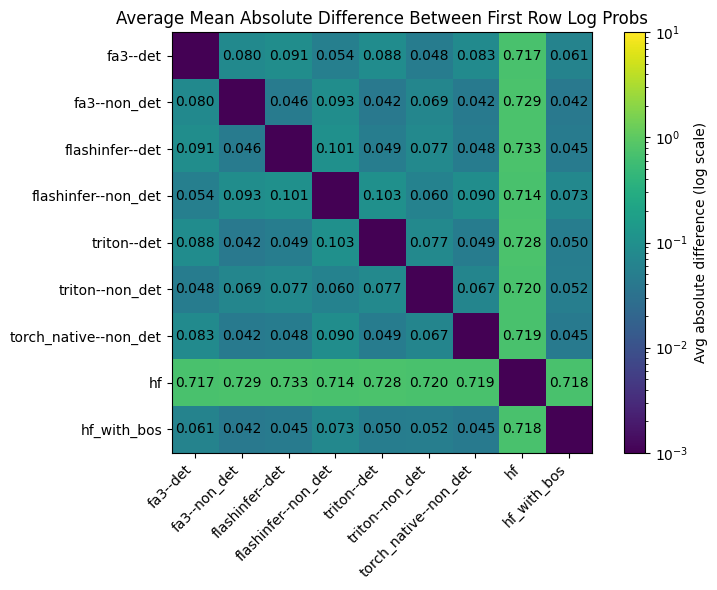

In [168]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Keys and first row denormalized values
keys = list(first_row_log_probs.keys())
n = len(keys)

# Initialize matrix to store average absolute differences
diff_matrix = np.zeros((n, n))

# Fill matrix
for i in range(n):
    for j in range(n):
        vals_i = np.array(first_row_log_probs[keys[i]])
        vals_j = np.array(first_row_log_probs[keys[j]])
        diff_matrix[i, j] = np.mean(np.abs(vals_i - vals_j))

# Add small epsilon to avoid log(0)
epsilon = 1e-10
diff_matrix_log = diff_matrix + epsilon

# Plot heatmap with log scale fixed between 1e-3 and 10^1
plt.figure(figsize=(8, 6))
im = plt.imshow(
    diff_matrix_log, 
    cmap='viridis', 
    interpolation='nearest', 
    norm=LogNorm(vmin=1e-3, vmax=1e1)
)

# Add colorbar
cbar = plt.colorbar(im)
cbar.set_label('Avg absolute difference (log scale)')

# Tick labels
plt.xticks(ticks=np.arange(n), labels=keys, rotation=45, ha='right')
plt.yticks(ticks=np.arange(n), labels=keys)

# Annotate each cell except diagonal
for i in range(n):
    for j in range(n):
        if i != j:  # Skip diagonal
            plt.text(
                j, i, f"{diff_matrix[i, j]:.3f}",
                ha='center', va='center',
                color='black'  # adjust for readability
            )

plt.title("Average Mean Absolute Difference Between First Row Log Probs")
plt.tight_layout()
plt.show()

# Let's Look at Extra Stuff in what SGL Returns
As per this return data it also returns input_token_logprobs and output_token_logprobs - https://github.com/sgl-project/sglang/blob/c15c864b6f2a5030e50b6a09b9b99b9783b95e99/python/sglang/lang/choices.py#L47


In [145]:
df_sgl_extra = pd.read_json('SGL_Outputs/sgl_logprobs_attn_backend_fa3_deterministic_false.jsonl', lines=True)

In [146]:
input_token_logprobs = df_sgl_extra['input_token_logprobs'].to_list()
choice_logliks = df_sgl_extra['choice_logliks'].to_list()

In [147]:
self_aggregated_logprobs = []
for idx, elem in enumerate(input_token_logprobs[0]):
    to_norm = []
    elem = elem[1:]
    for k in elem:
        to_norm.append(k[0])
    normed = sum(to_norm)/len(to_norm)
    assert np.isclose(normed,choice_logliks[0][idx]), f"{normed} != {choice_logliks[0][idx]}"

So aggregation in indeed just average and our approach is correct

Now let me confirm that the HF and SGL count same num of tokens

In [148]:
df_hf_extra = pd.read_json('HF_Outputs/hf_logprobs.jsonl', lines=True)

In [149]:
hf_token_wise_ll = df_hf_extra['result_token_wise'].to_list()

In [150]:
for elem_sgl, elem_hf in zip(input_token_logprobs[0], hf_token_wise_ll[0]):
    elem_sgl = elem_sgl[1:]
    assert len(elem_sgl) == len(elem_hf)

# Show some examples of SGL v/s HF

In [154]:
for elem_sgl, elem_hf in zip(input_token_logprobs[0], hf_token_wise_ll[0]):
    elem_sgl = elem_sgl[1:]
    sgl_lls = [i[0] for i in elem_sgl]
    hf_lls = [i[2] for i in elem_hf]
    print(f"HF {hf_lls} | SGL {sgl_lls}")

HF [-10.813740730285645] | SGL [-11.124578475952148]
HF [-10.464958190917969] | SGL [-9.250985145568848]
HF [-8.676277160644531, -1.157511472702026, -4.8910417556762695] | SGL [-9.438485145568848, -1.6952519416809082, -5.297178268432617]
HF [-7.821571350097656, -4.769257545471191, -3.918919563293457] | SGL [-7.6884846687316895, -5.468891143798828, -3.53694200515747]
HF [-7.393464088439941, -2.567721128463745, -0.153834253549575] | SGL [-8.938485145568848, -2.941343784332275, -0.149213433265686]
HF [-8.0464506149292, -0.750329196453094, -0.675131797790527] | SGL [-9.375985145568848, -0.44735288619995106, -0.284702658653259]
HF [-11.971717834472656, -1.313629150390625] | SGL [-12.750985145568848, -1.359178900718689]
HF [-7.008605003356934, -10.083311080932617, -2.775645017623901, -0.64925467967987] | SGL [-7.1259846687316895, -10.826095581054688, -3.070857524871826, -0.680258572101593]
HF [-9.10074520111084, -1.170117855072021, -0.26247775554656905] | SGL [-10.000985145568848, -0.1948720